In [7]:
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [9]:
from sklearn.metrics import mean_squared_error
from sklearn import cross_validation

In [10]:
import math

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

### Carga de los datos:

In [13]:
name_f="international-airline-passengers.csv"

In [14]:
dataframe = pd.read_csv(name_f, sep=',', usecols=[1], engine='python', skipfooter=3)
dataframe[:] = dataframe[:].astype('float32') 
df_train, df_test = dataframe[0:96].values, dataframe[96:].values

Escalamiento de los datos:

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(df_train)
stream_train_scaled = scaler.transform(df_train)
stream_test_scaled = scaler.transform(df_test)

In [16]:
def create_dataset(dataset,lag=1):
    t_data = len(dataset)
    dataset = dataset.reshape(t_data)
    dataY = dataset[lag:]
    t_dataY = len(dataY)
    dataX = np.zeros((t_dataY, lag))
    for i in range(t_dataY):
        dataX[i] = dataset[i:lag+i]
    return np.array(dataX),np.array(dataY)

**(K_1) En lugar de aumentar el numero de dimensiones como el el paso e), entrene la red con un timestep de 3 (con dimensión de entrada 1). ¿Se produce una mejora del error? ¿Los tiempos de computación son comparables? Comente brevemente.**

In [80]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)

In [81]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0],testX.shape[1],1))

In [82]:
%%time
model = Sequential()
model.add(LSTM(4, input_dim=1, activation='tanh', inner_activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=0)

CPU times: user 1min 30s, sys: 1min 6s, total: 2min 37s
Wall time: 1min 7s


In [83]:
trainPredict = model.predict(trainX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.95 RMSE
Test Score: 63.00 RMSE


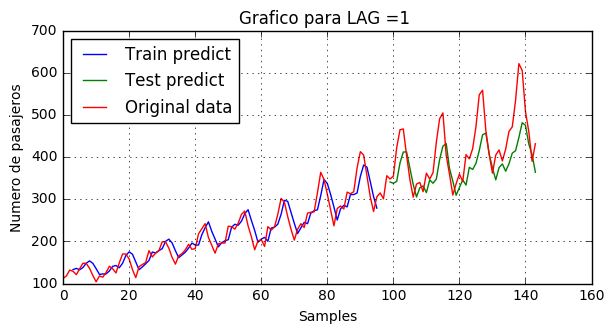

In [84]:
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict
plt.figure(figsize=(15, 15))
#####
plt.subplot(4, 2, 1)
plt.plot(trainPredictPlot) 
plt.plot(testPredictPlot)
plt.plot(dataframe)
plt.title('Grafico para LAG =1 ')  
plt.ylabel('Numero de pasajeros')  
plt.xlabel('Samples')  
plt.legend(['Train predict', 'Test predict', 'Original data'], loc='upper left')
plt.grid(True)
plt.show()

Los resultados obtenidos presentan una level mejora en terminos de disminuir la distancia entre el RMSE de entrenamiento(23.95) y el de testing (63.00) comparandolos con el modelo de la actividad (e) que fueron de Train Score: 23.23 RMSE y Test Score: 65.26 RMSE. Por lo cual esta estrategia resulta interesante, ahora será conveniente agregarle algunas de las otras mejoras detectadas.

**(k_2) Entrene la red LSTM con memoria entre batches.**

In [140]:
lag_ = 3
trainX, trainY = create_dataset(stream_train_scaled, lag_)
testX, testY = create_dataset(stream_test_scaled, lag_)

In [141]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0],testX.shape[1],1))

In [142]:
%%time
batch_size = 1
model_k = Sequential()
model_k.add(LSTM(4, batch_input_shape=(batch_size, lag_, 1), stateful=True, return_sequences=True))
model_k.add(LSTM(4, batch_input_shape=(batch_size, lag_, 1), stateful=True))
model_k.add(Dense(1))
model_k.compile(loss='mean_squared_error', optimizer='adam')
model_k.summary()
for i in range(100):
    model_k.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=0, shuffle=False)
    model_k.reset_states()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_47 (LSTM)               (1, 3, 4)                 96        
_________________________________________________________________
lstm_48 (LSTM)               (1, 4)                    144       
_________________________________________________________________
dense_32 (Dense)             (1, 1)                    5         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________
CPU times: user 3min 5s, sys: 2min 30s, total: 5min 36s
Wall time: 2min 27s


In [143]:
trainPredict = model.predict(trainX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.95 RMSE
Test Score: 63.00 RMSE


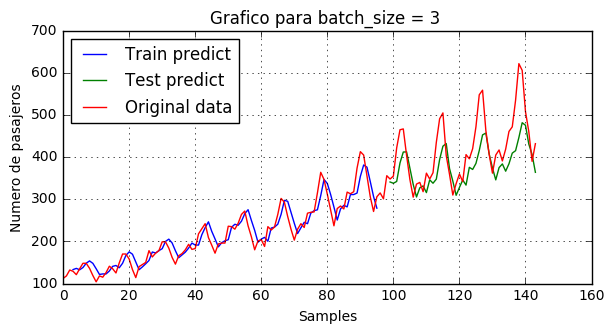

In [135]:
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag_:len(trainPredict)+lag_, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag_):, :] = testPredict
plt.figure(figsize=(15, 15))
#####
plt.subplot(4, 2, 1)
plt.plot(trainPredictPlot) 
plt.plot(testPredictPlot)
plt.plot(dataframe)
plt.title('Grafico para batch_size = 3 ')  
plt.ylabel('Numero de pasajeros')  
plt.xlabel('Samples')  
plt.legend(['Train predict', 'Test predict', 'Original data'], loc='upper left')
plt.grid(True)
plt.show()

Como podemos ver,como en el caso anterior, las curvas de de entrenamiento y testing tienen comportamientos disimiles, ahora bien el overfitting se mantiene, como se puede corroporar por el RMSE y visualment en el grafico.

**(l) Compare el resultado anterior usando un tamaño de batch de 3.**

In [91]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)

In [92]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0],testX.shape[1],1))

In [93]:
%%time
batch_size = 3
model_i = Sequential()
model_i.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True, return_sequences=True))
model_i.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True))
model_i.add(Dense(1))
model_i.compile(loss='mean_squared_error', optimizer='adam')
model_i.summary()
for i in range(100):
    model_i.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=0, shuffle=False)
    model_i.reset_states()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (3, 3, 4)                 96        
_________________________________________________________________
lstm_30 (LSTM)               (3, 4)                    144       
_________________________________________________________________
dense_23 (Dense)             (3, 1)                    5         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________
CPU times: user 1min 7s, sys: 46.2 s, total: 1min 53s
Wall time: 53.9 s


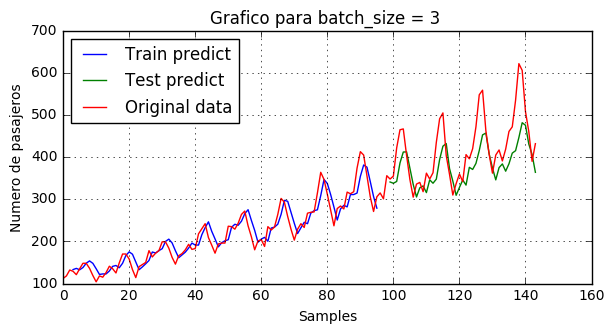

In [95]:
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict
plt.figure(figsize=(15, 15))
#####
plt.subplot(4, 2, 1)
plt.plot(trainPredictPlot) 
plt.plot(testPredictPlot)
plt.plot(dataframe)
plt.title('Grafico para batch_size = 3 ')  
plt.ylabel('Numero de pasajeros')  
plt.xlabel('Samples')  
plt.legend(['Train predict', 'Test predict', 'Original data'], loc='upper left')
plt.grid(True)
plt.show()

Como podemos ver la predicción conun batche igual a 3 aumenta notoriamente el error, en terminos experimentales para este problema podemos indicar que un batche = 1 presenta mejores resultados.

**(m) Construya una LSTM apilada, y comparela con la obtenida en k). Comente brevemente lo sucedido**

In [164]:
lag=3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [165]:
batch_size=3

In [166]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (3, 3, 4)                 96        
_________________________________________________________________
lstm_58 (LSTM)               (3, 4)                    144       
_________________________________________________________________
dense_37 (Dense)             (3, 1)                    5         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


In [167]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [168]:
histotiales = []
for i in range(100):
    histotiales.append(model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=0, shuffle=False))
    model.reset_states()

In [169]:
trainPredict = model.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

In [170]:
testPredict = model.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [175]:
scoreTrainMemS = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
scoreTestMemS = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

print("Training RMSE para LSTM con memoria entre batches: %.4f" % (scoreTrainMemS))
print("Testing RMSE para LSTM con memoria entre batches:: %.4f" % (scoreTestMemS))

Training RMSE para LSTM con memoria entre batches: 32.0914
Testing RMSE para LSTM con memoria entre batches:: 93.1760


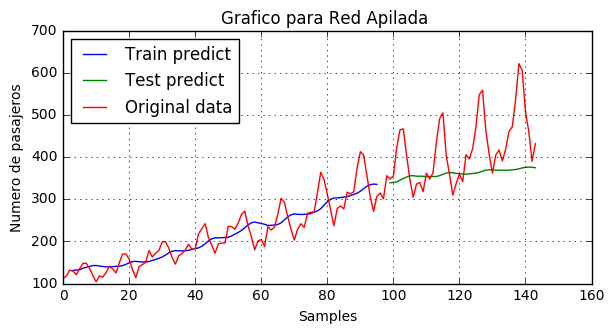

In [177]:
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict
plt.figure(figsize=(15, 15))
#####
plt.subplot(4, 2, 1)
plt.plot(trainPredictPlot) 
plt.plot(testPredictPlot)
plt.plot(dataframe)
plt.title('Grafico para Red Apilada ')  
plt.ylabel('Numero de pasajeros')  
plt.xlabel('Samples')  
plt.legend(['Train predict', 'Test predict', 'Original data'], loc='upper left')
plt.grid(True)
plt.show()


Tanto en los resultados:
- Training RMSE para LSTM con memoria entre batches: 32.0914
- Testing RMSE para LSTM con memoria entre batches:: 93.1760

Como en el grafico podemos ver el uso de la "profundidad" no controlada en las redes recurrentes resulta sumamente inefienciente, como vemos los resultados son malos primero por un overfitting marcado asi tambien por el prediccion que podemos ver en la grafica. Ahora esto puede tener muchas razones pero una de ella es el fenomeno conocido como el “desvanecimiento” del gradiente, que como se sabe la arquitectura de las redes RNN es similar al MLP, con la diferencia que esta permitido conexiones entre las neuronas ocultas, conexión asociada a un time delay(lag) esto con el fin que la red tenga la capacidad de descubrir correlaciones temporales, gracias a esta “memoria”. Esto es una característica potente pero así también es lo vuelve muy sensible al problema del “desvanecimiento” del gradiente porque si consideramos el BackPropagation aca también se realiza en el tiempo back-propagation through time (BPTT) podemos considerar a la RNN como redes profundas (en tiempo) por lo que podríamos decir que amplifican el problema en el tiempo